# Fourth model 

This model will try to predict wether pe is present or not on a full image (RGB level)

## Imports

In [2]:
import numpy as np
from balance import *
#from torchsummary import summary

In [3]:
import torch
torch.cuda.empty_cache()

print(f'PyTorch version: {torch.__version__}')
print("GPU found :)" if torch.cuda.is_available() else "No GPU :(")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

PyTorch version: 1.7.1
GPU found :)


# Load datasets

In [4]:
multi_image_dataset = torch.load('datasets/multi_image_dataset.pt')
nb_images = 50

## CNN

In [5]:
class ModelV4(nn.Module):
    
    def __init__(self, input_channels=3*nb_images):
        """Convnet with 4 convolution layer + pooling + BN, with 3 fully connected at the end"""
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=256, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(256, 512, 3)
        self.bn2 = nn.BatchNorm2d(512)
        self.conv3 = nn.Conv2d(512, 256, 3)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 64, 3)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(64*14*14 , 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)
        
        self.dropout = nn.Dropout(0.5)
        
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 64*14*14) # Flatten
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        
        # Binary classification
        out = self.sigmoid(self.fc3(x))
        
        return out

In [5]:
model = ModelV4().to(device)
#summary(model, (150, 256, 256))

## Split data into train and test

In [6]:
batch_size = 2
ratio=0.2

train_loader, test_loader = train_test_split(multi_image_dataset, ratio, batch_size)

print(f'Train size: {len(train_loader)}')
print(f'Test size: {len(test_loader)}')

Train size: 72
Test size: 18


## Model Training

In [7]:
num_epoch = 30
step_count = len(train_loader)
loss_function = nn.BCELoss()
losses = list()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epoch):
    
    epoch_loss = 0
    
    for i, sample in enumerate(train_loader):
        
        image = sample['image'].to(device, dtype=torch.float)
        target = sample['target'].to(device, dtype=torch.float)
        target = target.view(target.shape[0], 1)
        
        # Reset gradiant
        optimizer.zero_grad()
        
        # Forward pass
        pred = model(image)
        
        # Compute loss
        loss = loss_function(pred, target)
        epoch_loss += loss
        
        # Backprop
        loss.backward()
        optimizer.step()
        
        del image
        del target
        del pred
        del sample
        
        # Debug
        if((i+1) % 10 == 0):
            print(
                        f"Epoch [{epoch + 1}/{num_epoch}]"
                        f", step [{i + 1}/{step_count}]"
                        f", loss: {loss.item():.4f}"
                    )
            
    losses.append(epoch_loss)

Epoch [1/30], step [10/72], loss: 3.0015
Epoch [1/30], step [20/72], loss: 1.8430
Epoch [1/30], step [30/72], loss: 1.1515
Epoch [1/30], step [40/72], loss: 0.4439
Epoch [1/30], step [50/72], loss: 3.0187
Epoch [1/30], step [60/72], loss: 0.7358
Epoch [1/30], step [70/72], loss: 1.9809
Epoch [2/30], step [10/72], loss: 0.9579
Epoch [2/30], step [20/72], loss: 0.2688
Epoch [2/30], step [30/72], loss: 0.8959
Epoch [2/30], step [40/72], loss: 0.1908
Epoch [2/30], step [50/72], loss: 0.6346
Epoch [2/30], step [60/72], loss: 0.6501
Epoch [2/30], step [70/72], loss: 0.9049
Epoch [3/30], step [10/72], loss: 0.4758
Epoch [3/30], step [20/72], loss: 1.3479
Epoch [3/30], step [30/72], loss: 0.7052
Epoch [3/30], step [40/72], loss: 1.0295
Epoch [3/30], step [50/72], loss: 0.3774
Epoch [3/30], step [60/72], loss: 0.5993
Epoch [3/30], step [70/72], loss: 0.6180
Epoch [4/30], step [10/72], loss: 0.7291
Epoch [4/30], step [20/72], loss: 2.6632
Epoch [4/30], step [30/72], loss: 0.8675
Epoch [4/30], st

In [8]:
# Save model 
torch.save(model.state_dict(), './models/model_v4.h5')
del model

## Test the model

In [7]:
# Load model for evaluation
trained_model = ModelV4()
trained_model.load_state_dict(torch.load('./models/model_v4.h5'))
trained_model.to(device)

ModelV4(
  (conv1): Conv2d(150, 256, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
)

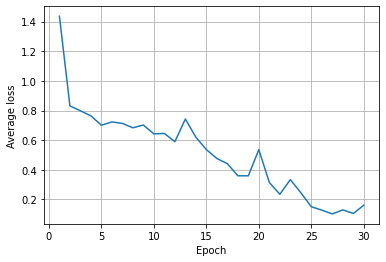

In [10]:
import matplotlib.pyplot as plt

epochs = list(range(1, num_epoch+1))
mean_losses = list(map(lambda x: x/step_count, losses))
plt.plot(epochs, mean_losses)
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.grid()
plt.savefig('Loss model v4 study level.png')
plt.show()

In [27]:
correct = 0
total = 0
with torch.no_grad():
    for sample in test_loader:
        
        images = sample['image'].to(device, dtype=torch.float)        
        targets = sample['target'].to(device)
        
        outputs = trained_model(images)
        class_0 = torch.full((targets.size(0),1), 0.5).to(device)
        outputs = torch.cat((class_0, outputs), 1)

        _, pred = torch.max(outputs.data, 1)
        
        total += targets.size(0)
        correct += (pred == targets).sum().item()

In [28]:
print(f'Accuracy of the network on the {total} test studies: {100 * correct / total:.2f}')

Accuracy of the network on the 36 test studies: 88.89
